In [1]:
import math 
import numpy as np

**Localización estimada a partir de dos puntos y un ángulo**

Introducimos los puntos de nuestra imagen y el ángulo que forman con la cámara. 

In [2]:
p1 = np.array([25,70])
p2 = np.array([40,110])
alpha = 30
alpha = alpha*2*np.pi/360

Calculamos ahora el vector $v=\overrightarrow{P_1P_2}=P_2-P_1$

In [3]:
v = p2-p1
print(v)

[15 40]


Y calculamos el vector ortogonal normalizado. 

In [4]:
vv = np.array([v[1],-v[0]])
print(vv)
norm = np.linalg.norm(v)
print(norm)
vv = vv / norm
print(vv)

[ 40 -15]
42.720018726587654
[ 0.93632918 -0.35112344]


Ahora calculamos $\tan(\frac{\alpha}{2})$:

In [5]:
tan = np.tan(alpha/2)
print(tan)

0.2679491924311227


Calculamos $h=\frac{\left\Vert P_{2}-P_{1}\right\Vert }{2\cdot\tan\left(\frac{\alpha}{2}\right)}$:

In [6]:
h = norm/(2*tan)
print(h)

79.7166401939595


Y ya podemos calcular $C$:

In [7]:
C = (p1+p2)/2 + h * vv
print(C)

[107.14101615  62.00961894]


Como podemos ver en la siguiente imagen, ¡funciona correctamente!

![getCamExample.png](getCamExample.png)
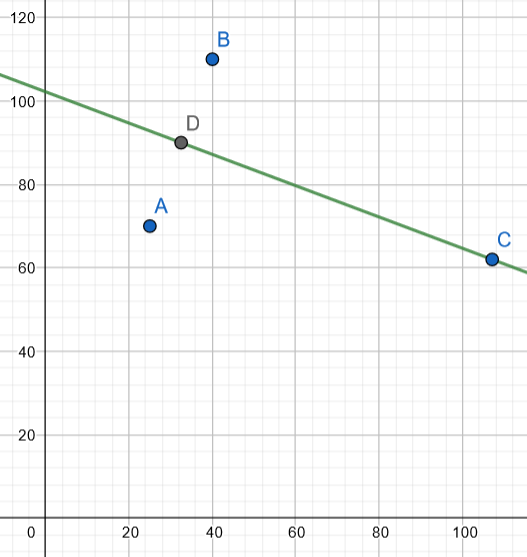

**Localización exacta a partir de tres puntos y dos ángulos conocidos**

Ahora conocemos 3 puntos y dos ángulos. Nótese que deben estar alineados, puesto que están en la misma foto y los estamos viendo desde arriba.

In [8]:
p1 = np.array([25,70])
p2 = np.array([40,110])
p3 = np.array([47.5,130])
alpha1 = 30
alpha1 = alpha1*2*np.pi/360
alpha2 = 20
alpha2 = alpha2*2*np.pi/360

Trasladamos para que sea $p_1=(0,0)$:

In [9]:
pp1 = np.array([0,0])
pp2 = p2-p1
pp3 = p3-p1

Y ahora rotamos para que los tres puntos caigan en el eje X:

In [10]:
e1 = np.array([1,0])
angle = -np.arccos(np.dot(pp2,e1)/np.linalg.norm(pp2))
print(angle)

rotMat = np.matrix([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
print(rotMat)

ppp2 = np.squeeze(np.asarray(rotMat@pp2))
print(ppp2)
ppp3 = np.squeeze(np.asarray(rotMat@pp3))
print(ppp3)

-1.2120256565243244
[[ 0.35112344  0.93632918]
 [-0.93632918  0.35112344]]
[42.72001873  0.        ]
[ 6.40800281e+01 -8.88178420e-16]


Como vemos, estos puntos ya tienen a 0 (o prácticamente 0) su coordenada $y$, y podemos continuar. Tomamos el vector normal unitario $v=(0,-1)$ y calculamos las bisectrices y las circunferencias respectivas.

In [11]:
from scipy.optimize import fsolve, least_squares

In [12]:
B12 = lambda t : np.array([ppp2[0]/2, -t], dtype = object)
B23 = lambda t : np.array([(ppp2[0]+ppp3[0])/2, -t], dtype = object)

d1 = lambda t : np.linalg.norm(np.sqrt(ppp2[0]**2/4+t**2))
d2 = lambda t : np.linalg.norm(np.sqrt((ppp2[0]-ppp3[0])**2/4+t**2))

C12 = lambda t, x : B12(t) + np.array([d1(t)*np.cos(x), d1(t)*np.sin(x)], dtype = object)
C23 = lambda t, x : B23(t) + np.array([d2(t)*np.cos(x), d2(t)*np.sin(x)], dtype = object)

Ahora buscamos $t_1$ y $t_2$ tales que los ángulos de los puntos de $C_{12}(t_1,0)=\alpha_1$ y $C_{23}(t_2,0)=\alpha_2$, y por tanto lo serán para cualquier ángulo:

In [13]:
cos1 = np.cos(alpha1)
eq1 = lambda t : np.dot(pp1-C12(t,0), ppp2-C12(t,0)) / (np.linalg.norm(pp1-C12(t,0))*np.linalg.norm(ppp2-C12(t,0))) - cos1
t1 = fsolve(eq1, 37)

cos2 = np.cos(alpha2)
eq2 = lambda t : np.dot(ppp2-C23(t,0), ppp3-C23(t,0)) / (np.linalg.norm(ppp2-C23(t,0))*np.linalg.norm(ppp3-C23(t,0))) - cos2
t2 = fsolve(eq2, 0)
print(t1)
print(t2)

[36.99662147]
[29.3430717]


In [14]:
print(B12(t1))
print(B23(t2))
print(C12(t1,0))
print(C23(t2,0))

[21.36000936329383 array([-36.99662147])]
[53.400023408234574 array([-29.3430717])]
[64.08002808988151 array([-36.99662147])]
[84.6262680901962 array([-29.3430717])]


Ahora tenemos que resolver la ecuación que hemos derivado en la memoria:

$t_1^2+\sqrt{\frac{x_2^2}{4}+t_1^2}\cdot(2t_2\cdot\sin\theta-x_3\cos\theta)+x_2x_3=0$

In [15]:
eq3 = lambda w : t1**2 + np.linalg.norm(np.sqrt(ppp2[0]**2/4+t1**2))*(2*t2*np.sin(w) - ppp3[0]*np.cos(w)) + ppp2[0]*ppp3[0]
w0 = fsolve(eq3, 0)
print(w0)

[-0.74134005]


C:\Users\Jose\AppData\Local\r-miniconda\envs\via\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Por lo tanto, ya tenemos el resultado, que no es más que $C_{12}(t_1,w_0)$

In [16]:
C = C12(t1, w0[0])
print(C)

[52.86877085946814 array([-65.84446279])]


Por último, invertimos la transformación de traslación y rotación:

In [17]:
rotMatInv = np.matrix([[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle), np.cos(-angle)]])
Cfinal = p1 + np.squeeze(np.asarray(rotMatInv@C))
print(Cfinal)

[array([105.21555647]) array([96.38303835])]


Y ya tenemos (¡al fin!) el resultado buscado. Comprobamos en la siguiente imagen que es verosímil:
![getCamExample2.png](getCamExample2.png)
